In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
df = pd.read_csv('processed_data.csv')
df

color  gender  score
0          1       0  -2.08
1          1       0  -2.84
2          0       0  -1.20
3          0       1  -1.29
4          0       1  -2.90
...      ...     ...    ...
16387      1       0  -1.74
16388      1       0  -2.50
16389      1       0  -3.12
16390      0       0  -2.03
16391      1       0  -2.75

[16392 rows x 3 columns]

In [3]:
def sample_size(population, size):
    if size is None:
        cochran_n = round(((1.96)**2 * 0.5 * 0.5)/ 0.02**2)
        n = round(cochran_n/(1+((cochran_n -1) /population)))
    elif size >= 0 and size < 1:
        n = round(population * size)
    elif size < 0:
        raise ValueError('Parameter "size" must be an integer or a proportion between 0 and 0.99.')
    elif size >= 1:
        n = size
    return n

def sample(df, strata, size=None, seed=None, keep_index= True):
    population = len(df)
    size = sample_size(population, size)
    tmp = df[strata]
    tmp['size'] = 1
    tmp_grpd = tmp.groupby(strata).count().reset_index()
    tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)

    # controlling variable to create the dataframe or append to it
    first = True
    for i in range(len(tmp_grpd)):
        # query generator for each iteration
        qry=''
        for s in range(len(strata)):
            stratum = strata[s]
            value = tmp_grpd.iloc[i][stratum]
            n = tmp_grpd.iloc[i]['samp_size']

            if type(value) == str:
                value = "'" + str(value) + "'"

            if s != len(strata)-1:
                qry = qry + stratum + ' == ' + str(value) +' & '
            else:
                qry = qry + stratum + ' == ' + str(value)

        # final dataframe
        if first:
            stratified_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            first = False
        else:
            tmp_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            stratified_df = stratified_df.append(tmp_df, ignore_index=True)

    return stratified_df.sample(frac=1).reset_index(drop=True)

In [4]:
def df_to_operating_tuple(df):
    return [(item['score'], (int(item['color']), int(item['gender']))) for index, item in df.iterrows()]

In [5]:
def generate(df, f = [0.5, 0.5], N = [2000, 2000]):
    data = []
    for i in [0, 1]:
        for j in [0, 1]:
            len_a = (1 - f[i]) * N[i] if j == 0 else f[i] * N[i]
            data.append(sample(df, i, j, int(len_a)))
    return pd.concat(data).sample(frac=1).reset_index(drop=True)

In [6]:
def repair(df):
    filename = 'temp_pre_pro.csv'
    repaired_filename = 'repaired_temp_pre_pro.csv'
    df.to_csv(filename)
    repair_command = "BlackBoxAuditing-repair {filename} {repaired_filename} 1 True -p 'color' -i 'gender'".format(filename=filename, repaired_filename=repaired_filename)
    !eval {repair_command}
    return pd.read_csv('repaired_temp_pre_pro.csv')[['color', 'gender', 'score']]

In [7]:
# return individuals with top percieved qualities
def getTop(df, top = 0.1):
    data = df.copy().sort_values(['score'], ascending=[0])
    items = data[:int(data.shape[0] * top)]
    return df_to_operating_tuple(items)

In [8]:
# Compute chances to be in top k% for aggregated groups before and after debiasing
# d => fixed biases []
# f => number of elements
def get_aggregated(data, N, Nsim, k_range):
    results = {'original': {0: [], 1: []},
               'debiased': {0: [], 1: []}}

    # shapes(invisible) => 0: circle; 1: stars
    # colors(visible) => 0: orange; 1: green
    groups = [0, 1]

    for k in k_range:
        simulations = {'original': {0: [], 1: []},
                       'debiased': {0: [], 1: []}}

        for i in tqdm(range(0, Nsim), 'Simulations for top : {}'.format(k*100)):

            # properties, perceived qualities and real qualities
            df_gen = sample(data, ['color', 'gender'], N)

            for group in groups:

                # compute expected chances to be in top
                exp = df_gen[(df_gen['color'] == group)].shape[0] / df_gen.shape[0]

                for approach in ['original', 'debiased']:
                    if approach == 'original':
                        top = getTop(df_gen, k)
                    else:
                        top = getTop(repair(df_gen), k)

                    # compute real chances to be in top
                    real = len([x for x in top if x[1][0] == group]) / len(top)
                    simulations[approach][group].append((real - exp) / exp)

        for group in [0, 1]:
            for approach in ['original', 'debiased']:
                results[approach][group].append(np.mean(simulations[approach][group]))
    return results

In [9]:
def plot_aggregated(results):
    colors = ['orange', 'green']
    styles = {'original': '-', 'debiased': '--'}

    for approach in ['original', 'debiased']:
        for group in [0, 1]:
            plt.plot(k_range, results[approach][group], color = colors[group], ls = styles[approach])
    plt.axhline(0, color='k', linestyle='dashed', linewidth=1)
    plt.xlabel('top k')
    plt.ylabel('representation bias')

In [10]:
# for quick results
Nsim = 5
print('Number of Simulations : ', Nsim)

# to fetch top k% candidates
k_range = [i / 100 for i in range(1, 101, 5)]
print('Ranking Indexes : ', k_range)

Number of Simulations :  5
Ranking Indexes :  [0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51, 0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96]


Simulations for top : 1.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 6.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 11.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 16.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 21.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 26.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 31.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 36.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 41.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 46.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 51.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 56.00000000000001:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 61.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 66.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 71.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 76.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 81.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 86.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 91.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 96.0:   0%|          | 0/5 [00:00<?, ?it/s]

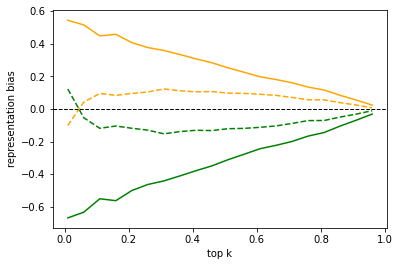

In [11]:
results_agg = get_aggregated(df, 4000, Nsim, k_range)
plot_aggregated(results_agg)

In [12]:

# Compute chances to be in top k% for disaggregated groups before and after debiasing
def get_disaggregated(data, N, Nsim, k_range):
    groups = [(0,0),(0,1),(1,0),(1,1)]

    results = {'original': {g:[] for g in groups},
               'debiased': {g:[] for g in groups}}

    for k in k_range:
        simulations = {'original': {g:[] for g in groups},
                       'debiased': {g:[] for g in groups}}

        for i in tqdm(range(0, Nsim), 'Simulations for top : {}'.format(k*100)):
            df_gen = sample(data, ['color', 'gender'], N)

            for g in groups:
                # compute expected chances to be in top
                # exp = len([x for x in a if x == g]) / len(q)
                exp = df_gen[(df_gen['color'] == g[0]) & (df_gen['gender'] == g[1])].shape[0] / df_gen.shape[0]
                for approach in ['original', 'debiased']:
                    if approach == 'original':
                       top = getTop(df_gen, k)
                    else:
                       top = getTop(repair(df_gen), k)

                    # compute real chances to be in top
                    real = len([x for x in top if x[1] == g]) / len(top)
                    simulations[approach][g].append((real - exp) / exp)

        for g in groups:
            for approach in ['original', 'debiased']:
                results[approach][g].append(np.mean(simulations[approach][g]))
    return results

In [13]:
def plot_disaggregated(results):
    groups = [(0,0),(0,1),(1,0),(1,1)]
    fill = {'original': 'full', 'debiased': 'none'}
    colors = ['orange', 'green']
    shapes = ['o', '*']
    for g in groups:
        for approach in ['original', 'debiased']:
            plt.plot(k_range, results[approach][g], shapes[g[1]], color = colors[g[0]], lw = 2, fillstyle = fill[approach])
    plt.axhline(0, color='k', linestyle='dashed', linewidth=1)
    plt.fill_between(k_range, results['debiased'][(0,1)], results['original'][(0,1)], color='orange', alpha=.25)
    plt.xlabel('top k')
    plt.ylabel('representation bias')

In [14]:
results = get_disaggregated(df, 4000, Nsim, k_range)

Simulations for top : 1.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 6.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 11.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 16.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 21.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 26.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 31.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 36.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 41.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 46.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 51.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 56.00000000000001:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 61.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 66.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 71.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 76.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 81.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 86.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 91.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top : 96.0:   0%|          | 0/5 [00:00<?, ?it/s]

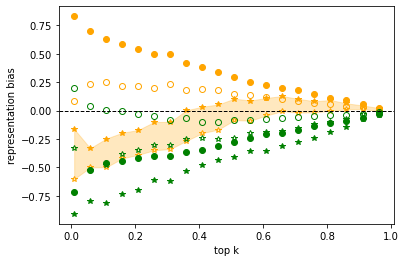

In [15]:
plot_disaggregated(results)

In [16]:
np.save('results_pre_compas.npy', {'agg': results_agg, 'diss_agg': results})

In [17]:
read_dictionary = np.load('results_pre_compas.npy', allow_pickle='TRUE').item()
read_dictionary

{'agg': {'original': {0: [0.5444368755676658,
    0.5156679533757191,
    0.44863223515812073,
    0.45813010899182566,
    0.40729780286319794,
    0.37706464402990286,
    0.3592216753098357,
    0.3342218563931779,
    0.30822888283378747,
    0.28393658926667453,
    0.2531849388256665,
    0.2259778853639549,
    0.19816727714000687,
    0.1811776140148075,
    0.16184646480152493,
    0.1350176573928008,
    0.11710902546506548,
    0.08480316519865663,
    0.05564806220119582,
    0.024892853088101744],
   1: [-0.6663979988882713,
    -0.6311844543264777,
    -0.5491318409217243,
    -0.5607573652028905,
    -0.4985379443606237,
    -0.4615321546158122,
    -0.43969212286395665,
    -0.40909201099376197,
    -0.3772762645914397,
    -0.347542173188003,
    -0.30990174279828664,
    -0.276599946398793,
    -0.24255939091845197,
    -0.22176381659844696,
    -0.19810223206945954,
    -0.16526341388490684,
    -0.14334300949086942,
    -0.10380020554054578,
    -0.06811397052086324